# Interactive Examples on Project Aria Tools

### Notebook stuck?
Note that because of Jupyter issues, sometimes the code may stuck at visualization. We recommend **restart the kernels** and try again to see if the issue is resolved.

In [9]:
# Specifics for Google Colab
google_colab_env = 'google.colab' in str(get_ipython())
if google_colab_env:
    print("Running from Google Colab, installing projectaria_tools and getting sample data")
    !pip install projectaria-tools
    !curl -O -J -L "https://github.com/facebookresearch/projectaria_tools/raw/main/data/mps_sample/sample.vrs"
    vrsfile = "sample.vrs"
else:
    print("Using a pre-existing projectaria_tool github repository")
    vrsfile = "../../data/mps_sample/sample.vrs"

Running from Google Colab, installing projectaria_tools and getting sample data
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 75.1M  100 75.1M    0     0  48.7M      0  0:00:01  0:00:01 --:--:--  224M


In [10]:
from projectaria_tools.core import data_provider, calibration
from projectaria_tools.core.sensor_data import TimeDomain, TimeQueryOptions
from projectaria_tools.core.stream_id import RecordableTypeId, StreamId
import numpy as np
from matplotlib import pyplot as plt

## Create data provider

In [11]:
print("Creating data provider from {vrsfile}")
provider = data_provider.create_vrs_data_provider(vrsfile)
if not provider:
    print("Invalid vrs data provider")

Creating data provider from {vrsfile}


# Summarize a VRS using thumbnails

Goals:
- Summarize a VRS using 10 image side by side

Key learnings:
- Image streams are identified with a Unique Identifier: stream_id
- PIL images can be created from Numpy array

100%|██████████| 10/10 [00:00<00:00, 12.54it/s]


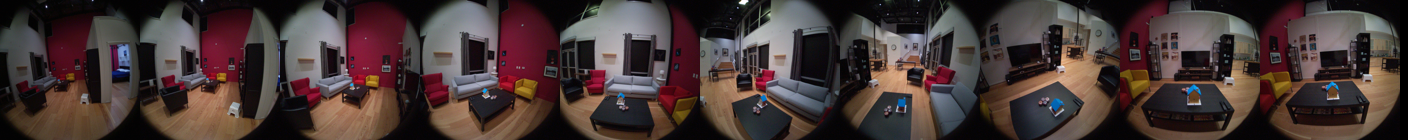

In [72]:
from PIL import Image
from tqdm import tqdm

rgb_stream_id = StreamId("214-1")


# Retrieve image size for the RGB stream
time_domain = TimeDomain.DEVICE_TIME  # query data based on host time
option = TimeQueryOptions.CLOSEST # get data whose time [in TimeDomain] is CLOSEST to query time

# Retrieve Start and End time for the given Sensor Stream Id
start_time = provider.get_first_time_ns(rgb_stream_id, time_domain)
end_time = provider.get_last_time_ns(rgb_stream_id, time_domain)

image_config = provider.get_image_configuration(rgb_stream_id)
width = image_config.image_width
height = image_config.image_height

sample_count = 10
resize_ratio = 10
thumbnail = newImage = Image.new(
    "RGB", (int(width * sample_count / resize_ratio), int(height / resize_ratio))
)
current_width = 0


# Samples 10 timestamps
sample_timestamps = np.linspace(start_time, end_time, sample_count)
for sample in tqdm(sample_timestamps):
    image_tuple = provider.get_image_data_by_time_ns(rgb_stream_id, int(sample), time_domain, option)
    image_array = image_tuple[0].to_numpy_array()
    image = Image.fromarray(image_array)
    new_size = (
        int(image.size[0] / resize_ratio),
        int(image.size[1] / resize_ratio),
    )
    image = image.resize(new_size).rotate(-90)
    thumbnail.paste(image, (current_width, 0))
    current_width = int(current_width + width / resize_ratio)

from IPython.display import Image
display(thumbnail)

## Pytorch Data Loaders Example (RGB)

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

class RGBDataset(Dataset):
    def __init__(self, start_time, end_time, sample_count, transform=None):
        self.timestamps = np.linspace(start_time, end_time, sample_count)
        self.rgb_stream_id = StreamId("214-1")
        self.time_domain = TimeDomain.DEVICE_TIME
        self.option = TimeQueryOptions.CLOSEST
        self.transform = transform

    def __len__(self):
        return len(self.timestamps)

    def __getitem__(self, idx):
        timestamp = self.timestamps[idx]
        image_tuple = provider.get_image_data_by_time_ns(self.rgb_stream_id, int(timestamp), self.time_domain, self.option)
        image_array = image_tuple[0].to_numpy_array()
        image = Image.fromarray(image_array).rotate(-90)
        if self.transform:
          image = self.transform(image)
        return timestamp, image

In [76]:
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
  ])

rgb_dataset = RGBDataset(start_time, end_time, sample_count, transform=val_transform)
image_dataloader = DataLoader(rgb_dataset, batch_size=2, shuffle=False)
# Get the next batch of data
timestamp, image = next(iter(image_dataloader))

In [18]:
class RGBSnippetDataset(Dataset):
    def __init__(self, start_time: float, end_time: float, snippet_dur_sec: int, frames_per_snippet: int, transform=None):
        self.start_time = start_time
        self.end_time = end_time
        self.snippet_dur = snippet_dur_sec * 1000000000 # duration of a snippet in nano seconds
        self.frames_per_snippet = frames_per_snippet # number of frames per snippet
        self.stride_ns = int(self.snippet_dur//frames_per_snippet)
        self.num_snippets = int((end_time - start_time) // self.snippet_dur)
        self.snippet_starts = np.arange(start_time, start_time + self.snippet_dur * self.num_snippets, self.snippet_dur)

        # Precompute all required timestamps for each snippet
        self.all_frame_timestamps = [np.arange(snippet_start, snippet_start + self.snippet_dur, self.stride_ns) for snippet_start in self.snippet_starts]

        self.rgb_stream_id = rgb_stream_id
        self.time_domain = time_domain
        self.option = option
        self.transform = transform

    def __len__(self):
        return self.num_snippets

    def __getitem__(self, idx):
        frame_timestamps = self.all_frame_timestamps[idx]

        image_list = []
        for timestamp in frame_timestamps:
            image_tuple = provider.get_image_data_by_time_ns(self.rgb_stream_id, int(timestamp), self.time_domain, self.option)
            image_array = image_tuple[0].to_numpy_array()
            image_list.append(image_array)

        frames = [torch.tensor(frame, dtype=torch.float32) for frame in image_list]
        frames = torch.stack(frames, dim=0)

        if self.transform:
          frames = self.transform(frames)

        snippet_start = self.snippet_starts[idx]
        snippet_end = snippet_start + self.snippet_dur

        return frames, snippet_start, snippet_end

In [25]:
import torchvision.transforms as transforms
import torchvision.transforms._transforms_video as transforms_video
import torch.nn as nn

class Permute(nn.Module):
    """
    Permutation as an op
    """
    def __init__(self, ordering):
        super().__init__()
        self.ordering = ordering

    def forward(self, frames):
        """
        Args:
            frames in some ordering, by default (C, T, H, W)
        Returns:
            frames in the ordering that was specified
        """
        return frames.permute(self.ordering)

crop_size = 224
val_transform = transforms.Compose([
    Permute([3, 0, 1, 2]),  # T H W C -> C T H W
    transforms.Resize(crop_size),
    transforms.CenterCrop(crop_size),
    transforms_video.NormalizeVideo(mean=[108.3272985, 116.7460125, 104.09373615000001], std=[68.5005327, 66.6321579, 70.32316305]),
])

In [45]:
rgb_snippet_dataset = RGBSnippetDataset(start_time, end_time, snippet_dur_sec = 2, frames_per_snippet=4, transform=val_transform)
snippet_dataloader = DataLoader(rgb_snippet_dataset, batch_size=2, shuffle=False)

## Run LaViLa auto-narration model

In [37]:
# install LaViLa as dependency
!pip install git+https://github.com/zhaoyang-lv/LaViLa

  Cloning https://github.com/zhaoyang-lv/LaViLa to /tmp/pip-req-build-3dm3jipx
  Running command git clone --filter=blob:none --quiet https://github.com/zhaoyang-lv/LaViLa /tmp/pip-req-build-3dm3jipx
  Resolved https://github.com/zhaoyang-lv/LaViLa to commit e143d74bf1e15f97ac47883b4316232c186d89a1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.1 MB/s eta 0:00:00
 

In [33]:
def decode_one(generated_ids, tokenizer):
    # get the index of <EOS>
    if tokenizer.eos_token_id == tokenizer.bos_token_id:
        if tokenizer.eos_token_id in generated_ids[1:].tolist():
            eos_id = generated_ids[1:].tolist().index(tokenizer.eos_token_id) + 1
        else:
            eos_id = len(generated_ids.tolist()) - 1
    elif tokenizer.eos_token_id in generated_ids.tolist():
        eos_id = generated_ids.tolist().index(tokenizer.eos_token_id)
    else:
        eos_id = len(generated_ids.tolist()) - 1
    generated_text_str = tokenizer.tokenizer.decode(generated_ids[1:eos_id].tolist())
    return generated_text_str

In [2]:
import os
import urllib.request
from collections import OrderedDict
import torch

from lavila.models.models import VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL, VCLM_OPENAI_TIMESFORMER_BASE_GPT2
from lavila.models.tokenizer import MyGPT2Tokenizer

DEFAULT_CHECKPOINT = 'vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth'
# DEFAULT_CHECKPOINT = 'vclm_openai_timesformer_large_336px_gpt2_xl.pt_ego4d.jobid_246897.ep_0003.md5sum_443263.pth'

def load_models_and_transforms(num_frames=4, ckpt_name=DEFAULT_CHECKPOINT, device='cpu'):
    ckpt_path = os.path.join('lavila/modelzoo/', ckpt_name)
    print(f"ckpt_path: {os.path.abspath(ckpt_path)}")
    os.makedirs('lavila/modelzoo/', exist_ok=True)
    if not os.path.exists(ckpt_path):
        print('downloading model to {}'.format(ckpt_path))
        urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/lavila/checkpoints/narrator/{}'.format(ckpt_name), ckpt_path)
    ckpt = torch.load(ckpt_path, map_location='cpu')
    state_dict = OrderedDict()
    for k, v in ckpt['state_dict'].items():
        state_dict[k.replace('module.', '')] = v

    # instantiate the model, and load the pre-trained weights
    # model = VCLM_OPENAI_TIMESFORMER_LARGE_336PX_GPT2_XL(
    model = VCLM_OPENAI_TIMESFORMER_BASE_GPT2(
        text_use_cls_token=False,
        project_embed_dim=256,
        gated_xattn=True,
        timesformer_gated_xattn=False,
        freeze_lm_vclm=False,      # we use model.eval() anyway
        freeze_visual_vclm=False,  # we use model.eval() anyway
        num_frames=num_frames,
        drop_path_rate=0.
    )
    model.load_state_dict(state_dict, strict=True)

    device_type_str = device.type if isinstance(device, torch.device) else device
    if device_type_str != 'cpu':
        model = model.to(device)
    model.eval()

    tokenizer = MyGPT2Tokenizer('gpt2', add_bos=True)
    #tokenizer = MyGPT2Tokenizer('gpt2-xl', add_bos=True)

    return model, tokenizer

In [3]:
model, tokenizer = load_models_and_transforms(num_frames=4)

ckpt_path: /content/lavila/modelzoo/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
downloading model to lavila/modelzoo/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
######USING ATTENTION STYLE:  frozen-in-time


100%|███████████████████████████████████████| 335M/335M [00:03<00:00, 88.5MiB/s]


=> Loading CLIP (ViT-B/16) weights
_IncompatibleKeys(missing_keys=['temporal_embed', 'blocks.0.timeattn.qkv.weight', 'blocks.0.timeattn.qkv.bias', 'blocks.0.timeattn.proj.weight', 'blocks.0.timeattn.proj.bias', 'blocks.0.norm3.weight', 'blocks.0.norm3.bias', 'blocks.1.timeattn.qkv.weight', 'blocks.1.timeattn.qkv.bias', 'blocks.1.timeattn.proj.weight', 'blocks.1.timeattn.proj.bias', 'blocks.1.norm3.weight', 'blocks.1.norm3.bias', 'blocks.2.timeattn.qkv.weight', 'blocks.2.timeattn.qkv.bias', 'blocks.2.timeattn.proj.weight', 'blocks.2.timeattn.proj.bias', 'blocks.2.norm3.weight', 'blocks.2.norm3.bias', 'blocks.3.timeattn.qkv.weight', 'blocks.3.timeattn.qkv.bias', 'blocks.3.timeattn.proj.weight', 'blocks.3.timeattn.proj.bias', 'blocks.3.norm3.weight', 'blocks.3.norm3.bias', 'blocks.4.timeattn.qkv.weight', 'blocks.4.timeattn.qkv.bias', 'blocks.4.timeattn.proj.weight', 'blocks.4.timeattn.proj.bias', 'blocks.4.norm3.weight', 'blocks.4.norm3.bias', 'blocks.5.timeattn.qkv.weight', 'blocks.5.tim

Loading LM from pretrained weights..
=> Initialize MyGPT2Tokenizer (gpt2)


In [56]:
def run_model_on_frames(frames, model, tokenizer, device="cpu", narration_max_sentences=5):
    with torch.no_grad():
        image_features = model.encode_image(frames)
        generated_text_ids, ppls = model.generate(
            image_features,
            tokenizer,
            target=None,  # free-form generation
            max_text_length=77,
            top_k=None,
            top_p=0.95,   # nucleus sampling
            num_return_sequences=narration_max_sentences,  # number of candidates: 10
            temperature=0.7,
            early_stopping=True,
        )
    output_narration = []
    for j in range(generated_text_ids.shape[0] // narration_max_sentences):
        cur_output_narration = []
        for k in range(narration_max_sentences):
            jj = j * narration_max_sentences + k
            generated_text_str = decode_one(generated_text_ids[jj], tokenizer)
            generated_text_str = generated_text_str.strip()
            generated_text_str = generated_text_str.replace("#c c", "#C C")
            if generated_text_str in cur_output_narration:
                continue
            if generated_text_str.endswith('the'):
                # skip incomplete sentences
                continue
            cur_output_narration.append(generated_text_str)
        output_narration.append(cur_output_narration) # list of size B (batch size)
    return output_narration

## LaViLa Inference on Single Batch

In [57]:
output_narration = run_model_on_frames(frames, model, tokenizer)
print(output_narration)

[['#C C looks at the window', '#C C looks around', '#C C looks at the ceiling', '#C C looks at the floor', '#C C looks at the wall'], ['#C C looks around', '#C C stares around the room', '#C C adjusts the camera', '#C C looks around the room']]


## LaViLa inference over multiple snippets

In [69]:
world_states = {
    'start_time_ns': [],
    'end_time_ns': [],
    'narration': [],
}

for idx, (frames, st_ns, ed_ns) in enumerate(snippet_dataloader):
  output_narration = run_model_on_frames(frames, model, tokenizer)
  world_states['start_time_ns'].extend(st_ns.numpy().tolist())
  world_states['end_time_ns'].extend(ed_ns.numpy().tolist())
  world_states['narration'].extend(output_narration)
  if idx == 1:
    break

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Display World States

In [70]:
import pandas as pd
pd.DataFrame(world_states)

,start_time_ns,end_time_ns,narration
0,148502526450,150502526450,"[#C C looks around, #C C stares the floor, #C ..."
1,150502526450,152502526450,"[#C C looks at the floor, #C C stares at the w..."
2,152502526450,154502526450,"[#C C looks around, #C C watches the televisio..."
3,154502526450,156502526450,"[#C C looks at the wall, #C C looks around, #C..."


In [71]:
!vrs -h

/bin/bash: line 1: vrs: command not found
